<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/Treinanco_Modelo_Reducing_Commercial_Aviation_Fatalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.model_selection import train_test_split

IN_COLAB = 'google.colab' in sys.modules

%matplotlib inline
plt.style.use('ggplot')

In [0]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/reducing-commercial-aviation-fatalities'
api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')

In [3]:
def get_kaggle_json():
    !mkdir -p ~/.kaggle
    !cp '{api_gdrive_credential_location}' '{api_local_credential_location}'

if IN_COLAB:
    if not os.path.isfile('train.csv.zip') or not os.path.isfile('test.csv.zip'):
        from google.colab import drive
        drive.mount('/gdrive')

        if os.path.isdir(gdrive_kaggle_dir):
            if os.path.isfile(f'{data_gdrive_dir}/test.csv.zip') and os.path.isfile(f'{data_gdrive_dir}/train.csv.zip'):
                !cp '{data_gdrive_dir}/train.csv.zip' .
                !cp '{data_gdrive_dir}/test.csv.zip' .
            else:
                get_kaggle_json()

if not os.path.isfile('train.csv.zip') or not os.path.isfile('test.csv.zip'):
    if os.path.isfile(api_local_credential_location):
        !pip -q install kaggle --upgrade
        !kaggle competitions download -c reducing-commercial-aviation-fatalities
        if IN_COLAB and os.path.isdir(gdrive_kaggle_dir):
            !cp train.csv.zip '{data_gdrive_dir}'
            !cp test.csv.zip '{data_gdrive_dir}'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
eeg_columns = ['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 
               'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3', 
               'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',	'eeg_c4', 
               'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2']

numeric_features = [*eeg_columns, 'ecg', 'r', 'gsr']
categorical_features = ['event']

In [0]:
dtypes = {'experiment': 'category', 'seat': bool, **{feature: np.float16 for feature in numeric_features}}

In [0]:
train_df = pd.read_csv('train.csv.zip', dtype=dtypes).set_index(['crew', 'experiment', 'seat', 'time'])

In [0]:
features = numeric_features
target = 'event'

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.30, random_state=42, stratify=train_df[target])

In [9]:
print(f'Quantidade de dados de treinamento: {y_train.shape[0]}')
print(f'Quantidade de dados de teste: {X_test.shape[0]}')

Quantidade de dados de treinamento: 3407194
Quantidade de dados de teste: 1460227


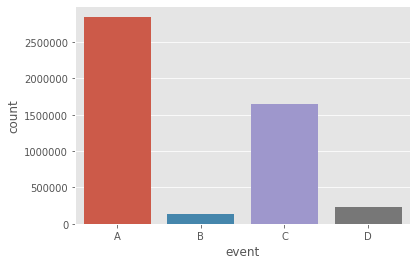

In [10]:
sns.countplot(train_df[target], order=['A', 'B', 'C', 'D']);

In [11]:
from imblearn.under_sampling import NearMiss

nr = NearMiss(n_jobs=-1)
balanced_X, balanced_y = nr.fit_sample(train_df[features], train_df[target])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [0]:
balanced_X = pd.DataFrame(balanced_X, columns=features)
balanced_y = pd.Series(balanced_y, name=target)

In [0]:
balanced_X_train, balanced_X_test, balanced_y_train, balanced_y_test = train_test_split(balanced_X, balanced_y, test_size=0.20, random_state=42)

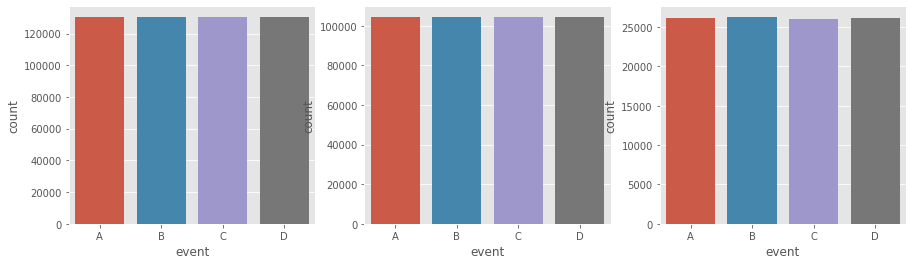

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

order = ['A', 'B', 'C', 'D']
sns.countplot(balanced_y, order=order, ax=ax[0]);
sns.countplot(balanced_y_train, order=order, ax=ax[1]);
sns.countplot(balanced_y_test, order=order, ax=ax[2]);

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        # ('cat', categorical_transformer, categorical_features)
        ])

In [16]:
from sklearn.linear_model import LogisticRegression

LR_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(n_jobs=-1))])

LR_clf.fit(balanced_X_train, balanced_y_train)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [0]:
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, classification_report

def show_metrics(model, X_test, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax[0])
    ax[0].set_title('Confusion matrix, without normalization')

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax[1])
    ax[1].set_title('Normalized confusion matrix')

    plt.tight_layout()
    plt.show()

    y_predict = model.predict(X_test)

    display(pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T)

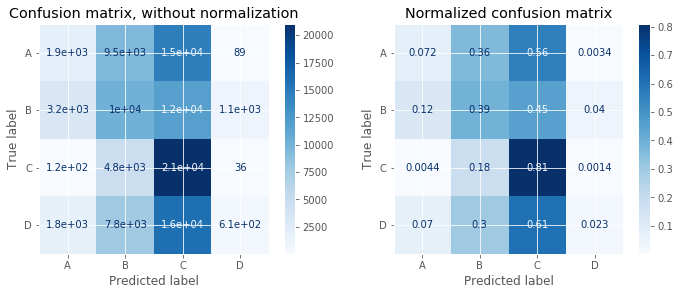

,precision,recall,f1-score,support
A,0.265985,0.071749,0.113013,26091.000000
B,0.315615,0.386855,0.347623,26307.000000
C,0.331724,0.809819,0.470655,25970.000000
D,0.337416,0.023209,0.043432,26110.000000
accuracy,0.322422,0.322422,0.322422,0.322422
macro avg,0.312685,0.322908,0.243681,104478.000000
weighted avg,0.312674,0.322422,0.243596,104478.000000


In [18]:
show_metrics(LR_clf, balanced_X_test, balanced_y_test)

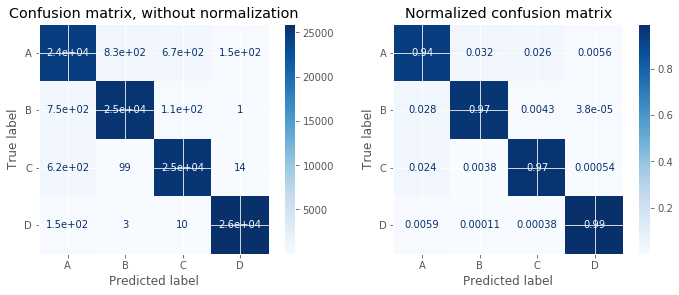

,precision,recall,f1-score,support
A,0.941435,0.937105,0.939265,26091.000000
B,0.964743,0.967347,0.966043,26307.000000
C,0.969683,0.971737,0.970709,25970.000000
D,0.993832,0.993604,0.993718,26110.000000
accuracy,0.967448,0.967448,0.967448,0.967448
macro avg,0.967423,0.967448,0.967434,104478.000000
weighted avg,0.967420,0.967448,0.967432,104478.000000


In [19]:
from sklearn.tree import DecisionTreeClassifier

DT_clf = DecisionTreeClassifier()
DT_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(DT_clf, balanced_X_test, balanced_y_test)

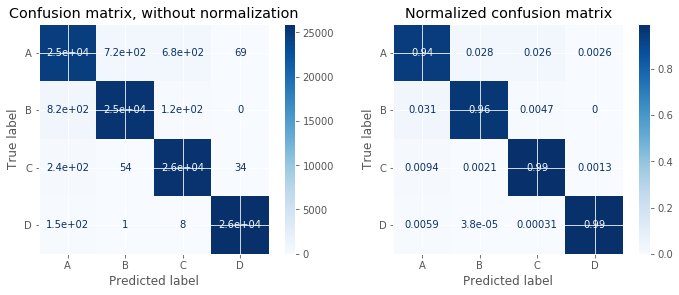

,precision,recall,f1-score,support
A,0.952973,0.943659,0.948293,26091.000000
B,0.970352,0.964192,0.967262,26307.000000
C,0.969265,0.987255,0.978177,25970.000000
D,0.996046,0.993757,0.994900,26110.000000
accuracy,0.972186,0.972186,0.972186,0.972186
macro avg,0.972159,0.972216,0.972158,104478.000000
weighted avg,0.972163,0.972186,0.972145,104478.000000


In [20]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(n_jobs=-1)
RF_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(RF_clf, balanced_X_test, balanced_y_test)

In [0]:
# RF_clf.fit(balanced_X, balanced_y)

In [0]:
test_df = pd.read_csv('test.csv.zip', usecols=features, dtype={feature: np.float16 for feature in numeric_features})

In [0]:
events = ['A','B','C', 'D']

pd.get_dummies(pd.Categorical(RF_clf.predict(test_df), categories=events)).rename(columns=str).reset_index().rename(columns={'index': 'id'}).to_csv('test_result.csv', index=False)

In [60]:
# get_kaggle_json()
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f test_result.csv -m "First Submission Train Set"

100% 281M/281M [00:08<00:00, 35.7MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

In [0]:
# from sklearn.ensemble import GradientBoostingClassifier

# GB_clf = GradientBoostingClassifier()
# GB_clf.fit(balanced_X_train, balanced_y_train)

# show_metrics(GB_clf, balanced_X_test, balanced_y_test)

In [22]:
if IN_COLAB:
    !pip install -q h2o

import h2o
from h2o.automl import H2OAutoML, get_leaderboard

h2o.init()

     |████████████████████████████████| 126.2MB 25kB/s 
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp4hz3w_9v
  JVM stdout: /tmp/tmp4hz3w_9v/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp4hz3w_9v/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,1 month
H2O cluster name:,H2O_from_python_unknownUser_537u5p
H2O cluster total nodes:,1
H2O cluster free memory:,6.188 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [32]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=10, max_runtime_secs=6000, max_runtime_secs_per_model=600)
aml.train(x=features, y=target, training_frame=h2o.H2OFrame(pd.concat([balanced_X, balanced_y], axis=1)))

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [33]:
lb = get_leaderboard(aml, extra_columns='ALL')
lb.head(rows=lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse,training_time_ms,predict_time_per_row_ms
XGBoost_2_AutoML_20200305_231356,0.0335134,0.651384,0.478625,0.229082,110353,0.003734
StackedEnsemble_AllModels_AutoML_20200305_231356,0.0367505,0.101535,0.170128,0.0289437,1.59517e+06,0.158532
StackedEnsemble_BestOfFamily_AutoML_20200305_231356,0.0383987,0.107196,0.174068,0.0302996,467758,0.041927
GBM_5_AutoML_20200305_231356,0.0418386,0.193451,0.219221,0.0480578,70286,0.01605
GBM_4_AutoML_20200305_231356,0.0483855,0.184535,0.221699,0.0491504,69267,0.019279
GBM_3_AutoML_20200305_231356,0.0611863,0.21062,0.243581,0.0593316,68116,0.022067
XGBoost_1_AutoML_20200305_231356,0.0640865,0.276273,0.276404,0.0763992,71284,0.014606
GBM_2_AutoML_20200305_231356,0.0688033,0.223654,0.253657,0.0643419,67535,0.023075
DRF_1_AutoML_20200305_231356,0.0701337,0.290988,0.287035,0.0823889,59257,0.021941
GBM_1_AutoML_20200305_231356,0.077318,0.247031,0.26908,0.0724039,67294,0.025385


In [34]:
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20200305_231356


Model Summary: 


,,number_of_trees
0,,15.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.2218395938884507
RMSE: 0.47099850731021503
LogLoss: 0.6380030322783364
Mean Per-Class Error: 0.025174774305688492

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,A,B,C,D,Error,Rate
0,124632.0,2104.0,3637.0,224.0,0.045675,"5,965 / 130,597"
1,3880.0,126142.0,571.0,4.0,0.034113,"4,455 / 130,597"
2,1559.0,128.0,128809.0,101.0,0.013691,"1,788 / 130,597"
3,848.0,41.0,54.0,129654.0,0.007221,"943 / 130,597"
4,130919.0,128415.0,133071.0,129983.0,0.025175,"13,151 / 522,388"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.974825
1,2,0.998319
2,3,0.999870
3,4,1.000000



ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.22908219696071616
RMSE: 0.47862532001631103
LogLoss: 0.651384465271902
Mean Per-Class Error: 0.03351340383010329

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,A,B,C,D,Error,Rate
0,122113.0,2919.0,5166.0,399.0,0.064963,"8,484 / 130,597"
1,4949.0,124872.0,770.0,6.0,0.043837,"5,725 / 130,597"
2,1709.0,204.0,128542.0,142.0,0.015735,"2,055 / 130,597"
3,1119.0,51.0,73.0,129354.0,0.009518,"1,243 / 130,597"
4,129890.0,128046.0,134551.0,129901.0,0.033513,"17,507 / 522,388"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.966487
1,2,0.997282
2,3,0.999853
3,4,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.9664866,0.0017621436,0.9666724,0.96588755,0.9662225,0.9644036,0.9692468
1,err,0.0335134,0.0017621436,0.03332759,0.034112446,0.033777446,0.035596352,0.03075318
2,err_count,3501.4,184.10677,3482.0,3564.0,3529.0,3719.0,3213.0
3,logloss,0.6513842,0.11341939,0.70659226,0.7062797,0.6750749,0.7184324,0.4505418
4,max_per_class_error,0.06496324,0.005659207,0.062136292,0.06420367,0.06248325,0.07488801,0.061104942
5,mean_per_class_accuracy,0.9664866,0.001762063,0.96667254,0.9658876,0.96622247,0.96440375,0.9692467
6,mean_per_class_error,0.033513412,0.001762063,0.03332747,0.034112398,0.033777565,0.035596278,0.03075334
7,mse,0.22908208,0.054022547,0.2554727,0.25530365,0.23984256,0.2612936,0.13349788
8,r2,0.8167345,0.043217536,0.7956219,0.7957602,0.808126,0.79096353,0.8932009
9,rmse,0.4753997,0.062019996,0.50544304,0.5052758,0.48973724,0.51116884,0.3653736



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
0,,2020-03-05 23:34:18,8 min 13.721 sec,0.0,0.750000,1.386294,0.750000
1,,2020-03-05 23:34:55,8 min 50.007 sec,5.0,0.647052,1.043113,0.031819
2,,2020-03-05 23:35:30,9 min 25.431 sec,10.0,0.556204,0.814712,0.027970
3,,2020-03-05 23:36:06,10 min 1.315 sec,15.0,0.470999,0.638003,0.025175



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,gsr,1.570094e+06,1.000000,0.325937
1,ecg,1.350949e+06,0.860426,0.280445
2,r,1.339027e+06,0.852832,0.277970
3,eeg_fp2,7.263934e+04,0.046264,0.015079
4,eeg_fp1,5.595013e+04,0.035635,0.011615
5,eeg_f7,5.314608e+04,0.033849,0.011033
6,eeg_f3,5.286027e+04,0.033667,0.010973
7,eeg_f8,4.802113e+04,0.030585,0.009969
8,eeg_f4,4.695535e+04,0.029906,0.009748
9,eeg_fz,3.390040e+04,0.021591,0.007037



See the whole table with table.as_data_frame()


In [0]:
events = ['A','B','C', 'D']

pd.get_dummies(pd.Categorical(aml.predict(h2o.H2OFrame(test_df)).as_data_frame(), categories=events)).rename(columns=str).reset_index().rename(columns={'index': 'id'}).to_csv('test_result.csv', index=False)

In [0]:
get_kaggle_json()
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f test_result.csv -m "Submission AutoML H2o"